# Qiskit Workshop: Solving Optimization Problems

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService #, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [2]:
from qiskit.primitives import Sampler

## Quadratic Unconstrained Binary Optimization (QUBO)

**Problem:** Given some combinatorial optimization problem with cost function $C(x)$,

<center>
    $\text{maximize } \;\;      C(x)$
 </center>
 <center>
    $\text{subject to } \;\; x \in S$
</center>

If $x$ are binary variables (i.e. $x \in \{0,1\}^n$), problem can be expressed as a Quadratic Unconstrained Binary Optimization (QUBO) problem. 

In [3]:
from qiskit_optimization import QuadraticProgram

qubo = QuadraticProgram()
qubo.binary_var('x')
qubo.binary_var('y')
qubo.binary_var('z')
qubo.minimize(linear=[1,-2,3], quadratic={('x', 'y'): 1, ('x', 'z'): -1, ('y', 'z'): 2})
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x - 2 y + 3 z + [ 2 x*y - 2 x*z + 4 y*z ]/2
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



In [4]:
op, offset = qubo.to_ising()
print('offset: {}'.format(offset))
print('operator:')
print(op)

offset: 1.5
operator:
-0.5 * IIZ
+ 0.25 * IZI
- 1.75 * ZII
+ 0.25 * IZZ
- 0.25 * ZIZ
+ 0.5 * ZZI


In [3]:
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.primitives import Sampler

algorithm_globals.random_seed = 10598

# Create classical optimizer for VQE
spsa = SPSA(maxiter=300)

# Generate ansatz circuit
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=5, entanglement='linear')

# Instantiate VQE
vqe = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=spsa)

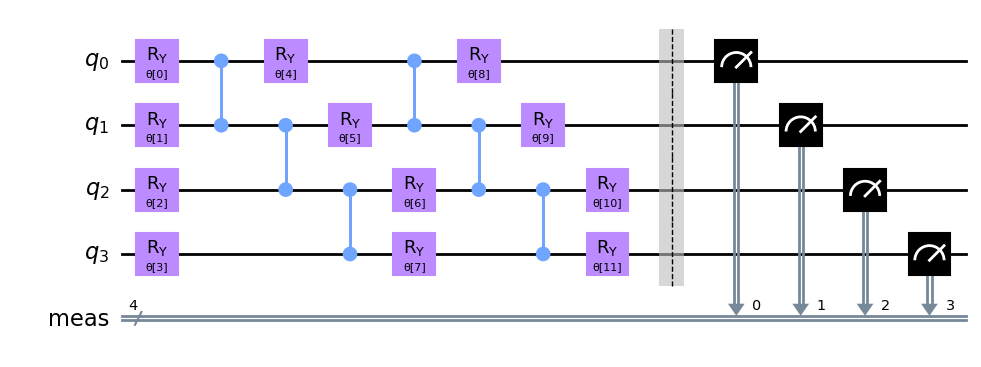

In [26]:
ansatz.decompose().draw()

In [4]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer

vqe_meo = MinimumEigenOptimizer(vqe)

In [7]:
result = vqe_meo.solve(qubo)
print(result)

fval=-2.0, x=0.0, y=1.0, z=0.0, status=SUCCESS


---

## Max-Cut problem

**Problem:** Consider an undirected weighted graph. Partition the graph into two subsets such that the sum of the weights in the edges connecting nodes between the two different subsets is maximized.

In [8]:
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline

import numpy as np

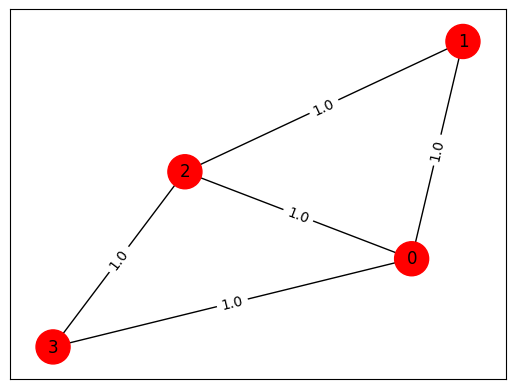

In [9]:
# Number of nodes in graph
n = 4

# Generate a graph
G = nx.Graph()
G.add_nodes_from(np.arange(0,n,1))

# Apply edge weights
# Note: tuple is (i,j,weight) where (i,j) is the edge
elist = [(0,1,1.0), (0,2,1.0), (0,3,1.0), (1,2,1.0), (2,3,1.0)]
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

### Step 0: Generate the weight matrix of the graph

In [12]:
w = np.zeros([n,n])

for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
            
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


### Step 1: Use the `Maxcut` to generate a Quadratic Program

In [33]:
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.problems import QuadraticProgram

# Intantiate Maxcut
#max_cut = Maxcut(graph=w)

# Can also provide the NetworkX graph object instead
max_cut = Maxcut(graph=G)

# Convert to quadratic program
qp = max_cut.to_quadratic_program()

print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 2 x_1 + 3 x_2 + 2 x_3 + [ - 4 x_0*x_1 - 4 x_0*x_2 - 4 x_0*x_3
      - 4 x_1*x_2 - 4 x_2*x_3 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



### Step 2: Create solver

Construct a minimum eigensolver instance to solve the problem.
In this case, use `VQE`.

In [16]:
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE

# Create classical optimizer for VQE
spsa = SPSA(maxiter=300)

# Generate ansatz circuit
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=2, entanglement='linear')

# Instantiate VQE
vqe = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=spsa)

### Step 3: Compute optimal solution

In [15]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

fval=4.0, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, status=SUCCESS


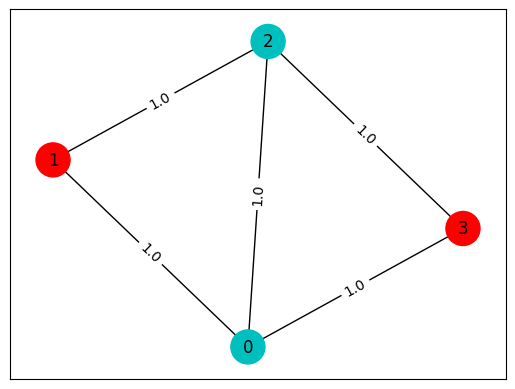

In [18]:
# solve quadratic program
result = vqe_optimizer.solve(problem=qp)
print(result)

# Plot graph of solution
colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

### Solving with QAOA

In [29]:
from qiskit.algorithms.minimum_eigensolvers import QAOA

qaoa = QAOA(sampler=Sampler(), optimizer=spsa)
qaoa_meo = MinimumEigenOptimizer(qaoa)

qaoa_result = qaoa_meo.solve(qp)
print(qaoa_result)

fval=4.0, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, status=SUCCESS


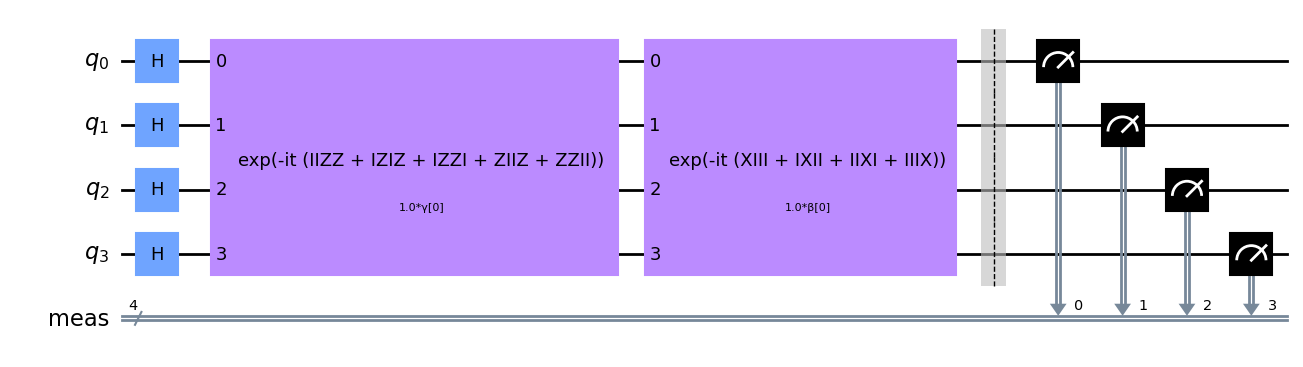

In [30]:
qaoa.ansatz.draw()

### Using IBM Runtime for cloud simulator and real hardware

In [39]:
from qiskit_ibm_runtime import Sampler as SamplerRT
from qiskit_ibm_runtime import Session

In [13]:
def qaoa_callback(count, params, mean, metadata):
    if count % 10 == 0:
        print('Iteration:', count, ', value:', mean)

In [42]:
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    sampler_rt = SamplerRT(session=session)
    qaoa = QAOA(sampler=sampler_rt, optimizer=spsa, callback=qaoa_callback)
    qaoa_meo = MinimumEigenOptimizer(qaoa)
    qaoa_result = qaoa_meo.solve(qp)
    
print(qaoa_result)

Iteration: 10 , value: (-0.4825+0j)
Iteration: 20 , value: (-0.50125+0j)
Iteration: 30 , value: (-0.48224999999999996+0j)
Iteration: 40 , value: (-0.48275000000000007+0j)
Iteration: 50 , value: (0.0355+0j)
Iteration: 60 , value: (-0.413+0j)
Iteration: 70 , value: (-0.43700000000000006+0j)
Iteration: 80 , value: (-0.47799999999999987+0j)
Iteration: 90 , value: (-0.47875000000000006+0j)
Iteration: 100 , value: (-0.5320000000000001+0j)
Iteration: 110 , value: (-0.4675+0j)
Iteration: 120 , value: (-0.52175+0j)
Iteration: 130 , value: (-0.45699999999999996+0j)
Iteration: 140 , value: (-0.528+0j)
Iteration: 150 , value: (-0.5207499999999999+0j)
Iteration: 160 , value: (-0.54725+0j)
Iteration: 170 , value: (-0.5015000000000001+0j)
Iteration: 180 , value: (-0.56475+0j)
Iteration: 190 , value: (-0.495+0j)
Iteration: 200 , value: (-0.4805000000000001+0j)
Iteration: 210 , value: (-0.5750000000000001+0j)
Iteration: 220 , value: (-0.5387500000000001+0j)
Iteration: 230 , value: (-0.47125+0j)
Iterati

---

## Traveling Salesman Problem (TSP)

**Problem:** Consider a weighted graph where the edge weights denote the cost of moving along that edge. Compute the lowest-cost round-trip path that minimizes the total cost.

In [45]:
from qiskit_optimization.applications import Tsp

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


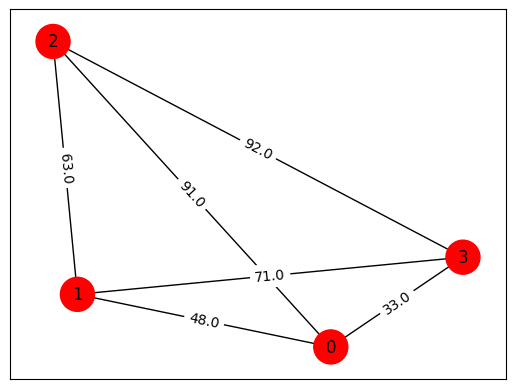

In [46]:
# Generating a random graph
n = 4
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print('distance\n', adj_matrix)

# Plot the graph
colors = ['r' for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]['pos']  for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

### Step 1: Convert TSP to quadratic program

In [47]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

### Step 2: Construct solver

In [50]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA

qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100), callback=qaoa_callback)
qaoa_meo = MinimumEigenOptimizer(qaoa)

### Step 3: Compute solution

In [51]:
qaoa_result = qaoa_meo.solve(qp)
print(qaoa_result)

Iteration: 10 , value: (895.5061954227932+0j)
Iteration: 20 , value: (13.87942681001451+0j)
fval=236.0, x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0, status=SUCCESS


In [52]:
z = tsp.interpret(qaoa_result.x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, adj_matrix))

solution: [3, 2, 1, 0]
solution objective: 236.0


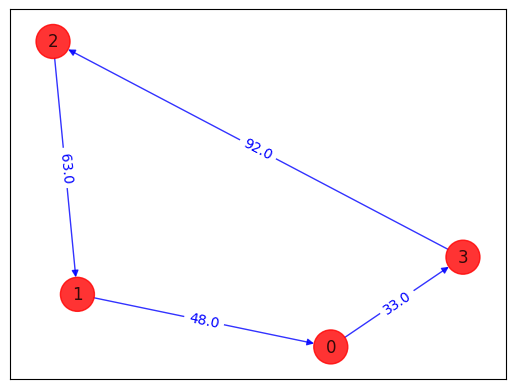

In [53]:
draw_tsp_solution(tsp.graph, z, colors, pos)

In [44]:
%qiskit_version_table